In [ ]:

!pip install kaggle split-folders torch torchvision


!kaggle datasets download -d emmarex/plantdisease -p ./data --unzip


import os


root_folder = "./data/PlantVillage"
if not os.path.exists(root_folder):
    raise ValueError("Dataset not found at expected location.")


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement kaggle (from versions: none)
ERROR: No matching distribution found for kaggle


HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/metadata/emmarex/plantdisease (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002A63C6B2660>: Failed to resolve 'www.kaggle.com' ([Errno 11001] getaddrinfo failed)"))


spliting the data into training and validation in 80,20

In [ ]:
import splitfolders

splitfolders.ratio(
    root_folder,
    output="./data/output",
    seed=42,
    ratio=(0.8, 0.2) 
)



Copying files: 20639 files [00:34, 605.57 files/s]


to see folders are exist or not , basically for recheck

In [3]:
import os
print("Train exists?", os.path.exists("./data/output/train"))
print("Val exists?", os.path.exists("./data/output/val"))
print("Classes in train:", os.listdir("./data/output/train"))
print("Classes in val:", os.listdir("./data/output/val"))


Train exists? True
Val exists? True
Classes in train: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Classes in val: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


Loading data and preprocessing here

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_dir = "./data/output"

transform = transforms.Compose([
    transforms.Resize((128, 128)),                            # changing images into 128 x 128
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"),   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("Number of classes:", num_classes)


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15


In [9]:
print(len(train_dataset), len(val_dataset))


16504 4134


cnn model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # till now we have getted the batches and c,h,w is (128,16,16)
        self.fc_layers = nn.Sequential(                                  #fully connected 
            nn.Flatten(),                                   
            nn.Linear(128 * 16 * 16, 256),                              # now we have getted the batches and c,h,w is (256,16,16)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = PlantDiseaseCNN(num_classes).to(device)
print(model)

my_lose = nn.CrossEntropyLoss()                                # probability(model,true)predict
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
best_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = my_lose(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = my_lose(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_plant_disease_model.pth")
        print("✅ Saved Best Model")

print(f"Training Finished. Best Validation Accuracy: {best_acc:.2f}%")

Using device: cpu
PlantDiseaseCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=15, bias=True)
  )
)
Epoch [1/10] Loss: 1.1056 | Train Acc: 64.01% | Val Acc: 83.65%
✅ Saved Best Model
Epoch [2/10] Loss: 0.5503 | Train Acc: 81.81% | Val Acc: 90.71%
✅ Sav

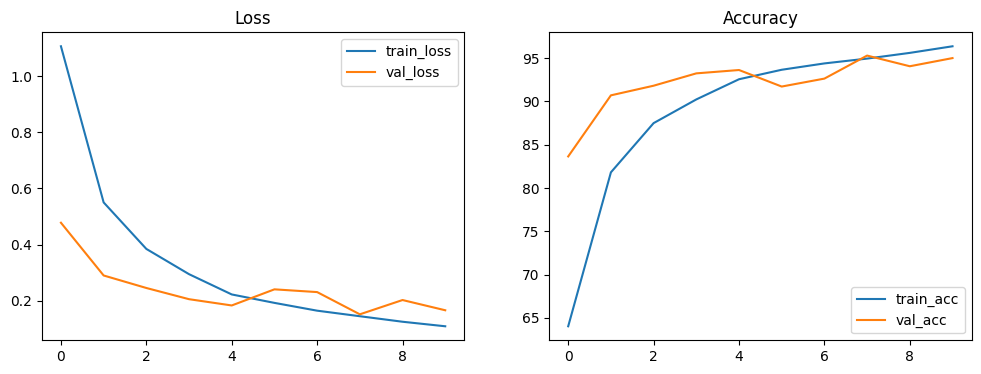

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='train_acc')
plt.plot(val_accuracies, label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.show()

In [24]:
from PIL import Image
import torch
from torchvision import transforms

# 1. Load saved model
model = PlantDiseaseCNN(num_classes)  # Define the model architecture
model.load_state_dict(torch.load("best_plant_disease_model.pth"))
model.eval()  # Set model to evaluation mode

# 2. Define transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 3. Load and preprocess a new image
img_path = 'ca2020_early_blight_potato_damage2.png'
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# 4. Predict disease
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

# 5. Map prediction to label
class_names = train_dataset.classes  # List of class labels from your dataset
predicted_label = class_names[predicted_class.item()]

print(f"Predicted disease: {predicted_label}")


Predicted disease: Tomato_Late_blight


testing images

In [ ]:
OIP.jpeg
C:/Users/Nitin Dumka/OneDrive/Desktop/Tomato_bacterial_spot01.jpg
0fcbdf76-fcc4-4271-986a-9466a784d404___JR_B.Spot 3374.JPG
2df35be7-ba8c-4ff6-a608-f7c481c59ede___PSU_CG 2202.JPG
0f6a5f32-3d95-4ef1-bc01-ba36f2efb2b4___Com.G_SpM_FL 1661.JPG
0b3778d6-b81e-43eb-9512-7e9067a9ca8f___UF.GRC_YLCV_Lab 08551.JPG
